# Momentum Factor

## Import Modules

In [164]:
import FinanceDataReader as fdr

from pykrx import stock

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytimekr import pytimekr
import datetime
from datetime import timedelta

import time
import pickle

## Load Datasets(with Absolute Momentum Factor calcuated as MA120)

In [2]:
stock_data = pd.read_csv('./mom_data.csv', index_col = 0, parse_dates=['날짜'], dtype = {'티커' : 'str'})
stock_data

,티커,종목명,날짜,시가,고가,저가,종가,거래량,등락률,ABS_MOM
0,060310,3S,2003-01-02,1037.0,1107.0,1007.0,1081.0,164270.0,7.135778,0.000000
1,060310,3S,2003-01-03,1095.0,1173.0,1095.0,1111.0,238965.0,2.775208,-2.180285
2,060310,3S,2003-01-06,1114.0,1132.0,1075.0,1119.0,144530.0,0.720072,-2.823614
3,060310,3S,2003-01-07,1138.0,1187.0,1095.0,1111.0,168800.0,-0.714924,-3.193958
4,060310,3S,2003-01-08,1101.0,1126.0,1074.0,1086.0,132570.0,-2.250225,-3.783407
...,...,...,...,...,...,...,...,...,...,...
4942,238490,힘스,2022-12-23,6050.0,6050.0,5950.0,6020.0,9421.0,-0.495868,-0.335925
4943,238490,힘스,2022-12-26,5940.0,6070.0,5860.0,5860.0,24368.0,-2.657807,-2.491430
4944,238490,힘스,2022-12-27,5940.0,5990.0,5860.0,5950.0,7276.0,1.535836,1.698196
4945,238490,힘스,2022-12-28,5880.0,5970.0,5870.0,5940.0,6909.0,-0.168067,0.008601


#1. 모든 날짜에 대하여, 즉, 2003년 1월 2일부터 2022년 12월 29일까지 모든 날(약 4000~5000건)에 대해 for loop 실행.

#2. 만약 3개월(1주일에 약 5영업일, 한달에 약 20영업일, 3달에 약 60영업일)이 경과했으면, 리밸런싱.

#3. 3개월마다 절대모멘텀(ABS_MOM) 기준 상위 20% 종목 long position, 하위 20% 종목 short position

#4. long인 경우에는 해당 종목 종가만큼 마이너스로 장부에 기록. 대신 count를 +1 

    반대로 short인 경우에는 해당 종목 종가만큼 플러스로 장부에 기록. 대신 count를 -1

#5. 다음 리밸런싱 주기에 이전 포트폴리오에 있는 모든 종목 청산 및 리밸런싱.
#6. for loop 동안 리밸런싱 일자별로 자산의 변화 기록.



## Performance of Momentum Factor Portfolio(2003.4.1~2022.12.31)

### *Rebalancing Period : 60 business day
### *Long/Short Quantile : 20%
- 오류 발생 및 수익률이 지나치게 낮아 데이터 전처리 필요

In [156]:
rbl_period = 60

dt = stock_data['날짜'].unique()
money = 10000 #초기 계좌 금액 = 10000원
history = []
long = None
short = None


for i, date in enumerate(dt[rbl_period::rbl_period]) : 
    start = time.time()
    #Rebalancing
    if long is not None : 
        print(f"\tBalancing Accounts ... ({pd.to_datetime(date).strftime('%Y-%m-%d')})")
        temp_long = stock_data[(stock_data['티커'].isin(long['티커'])) & (stock_data['날짜'] == date)]
        temp_short = stock_data[(stock_data['티커'].isin(short['티커'])) & (stock_data['날짜'] == date)]
        money += sum(temp_long['종가'].to_numpy()* np.array(long_count))
        money -= sum(temp_short['종가'].to_numpy() * np.array(short_count))

    history.append(money)
    long_count = []
    short_count = []

    print(f"[{i+1}/{len(dt[rbl_period::rbl_period])}] Constructing Long/Short Portfolios ... ({pd.to_datetime(date).strftime('%Y-%m-%d')}))")
    #Buy or Sell
    temp =stock_data[stock_data['날짜'] == date]
    q_long = temp['ABS_MOM'].quantile(q=0.8)
    q_short = temp['ABS_MOM'].quantile(q=0.2)
    long = temp[(temp['ABS_MOM'] >= q_long)&(temp['ABS_MOM'] > 0)]
    short = temp[(temp['ABS_MOM'] <= q_short)&(temp['ABS_MOM'] < 0)]
    #long/short에 대해 100원어치의 주식만 buy/sell
    #long pos
    for stock in long.itertuples() : 
        price = stock[7]
        money -= 100 
        if i == len(dt[rbl_period::rbl_period]) - 1 : 
            break
        if stock[1] not in stock_data[stock_data['날짜'] == dt[2*rbl_period::rbl_period ]][i]['티커'].to_numpy() : 
            print(f'[{stock[1]}] in bankruptcy')
            
        else :                                          
            long_count.append(1/price * 100)
    #short pos
    for stock in short.itertuples() : 
        price = stock[7]
        money += 100
        if i == len(dt[rbl_period::rbl_period]) - 1 : 
            break
        if stock[1] not in stock_data[stock_data['날짜'] == dt[2*rbl_period::rbl_period ]][i]['티커'].to_numpy() : 
            print(f'[{stock[1]}] in bankruptcy')
        
        else : 
            short_count.append(1/price * 100)
    end = time.time()
    print(history)
    print(f'{end - start : .3f} sec')
with open('mom_backtesting_history.p', 'wb') as f:
    pickle.dump(data, f)
history
        

[1/82] Constructing Long/Short Portfolios ... (2003-03-28))



KeyboardInterrupt



### *Rebalancing Period : 60 business day
### *Long Only : 20%

In [157]:
rbl_period = 60

dt = stock_data['날짜'].unique()
money = 10000 #초기 계좌 금액 = 10000원
history = []
long = None
short = None


for i, date in enumerate(dt[rbl_period::rbl_period]) : 
    start = time.time()
    #Rebalancing
    if long is not None : 
        print(f"\tBalancing Accounts ... ({pd.to_datetime(date).strftime('%Y-%m-%d')})")
        temp_long = stock_data[(stock_data['티커'].isin(long['티커'])) & (stock_data['날짜'] == date)]
        money += sum(temp_long['종가'].to_numpy()* np.array(long_count))

    history.append(money)
    long_count = []
    short_count = []

    print(f"[{i+1}/{len(dt[rbl_period::rbl_period])}] Constructing Long/Short Portfolios ... ({pd.to_datetime(date).strftime('%Y-%m-%d')}))")
    #Buy or Sell
    temp =stock_data[stock_data['날짜'] == date]
    q_long = temp['ABS_MOM'].quantile(q=0.8)
    long = temp[(temp['ABS_MOM'] >= q_long)&(temp['ABS_MOM'] > 0)]
    #long/short에 대해 100원어치의 주식만 buy/sell
    #long pos
    for stock in long.itertuples() : 
        price = stock[7]
        money -= 100 
        if i == len(dt[rbl_period::rbl_period]) - 1 : 
            break
        if stock[1] not in stock_data[stock_data['날짜'] == dt[2*rbl_period::rbl_period ]][i]['티커'].to_numpy() : 
            print(f'[{stock[1]}] in bankruptcy')
        else :                                          
            long_count.append(1/price * 100)
    end = time.time()
    print(history)
    print(f'{end - start : .3f} sec')
with open('mom_backtesting_OnlyLong_history.p', 'wb') as f:
    pickle.dump(data, f)
history
        

[1/82] Constructing Long/Short Portfolios ... (2003-03-28))
[10000]
 7.148 sec
	Balancing Accounts ... (2003-06-26)
[2/82] Constructing Long/Short Portfolios ... (2003-06-26))
[10000, 17033.005560685215]
 7.711 sec
	Balancing Accounts ... (2003-09-25)
[3/82] Constructing Long/Short Portfolios ... (2003-09-25))
[10000, 17033.005560685215, 16902.76360611671]
 6.945 sec
	Balancing Accounts ... (2003-12-19)
[4/82] Constructing Long/Short Portfolios ... (2003-12-19))
[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454]
 7.318 sec
	Balancing Accounts ... (2004-03-23)
[5/82] Constructing Long/Short Portfolios ... (2004-03-23))
[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304]
 7.298 sec
	Balancing Accounts ... (2004-06-21)
[6/82] Constructing Long/Short Portfolios ... (2004-06-21))
[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757]
 7.418 sec
	Balancing Accounts ... (2004-09-13)
[7/82] Cons

[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.81760043732, 32191.90616480328, 36642.19150633965]
 8.810 sec
	Balancing Accounts ... (2009-04-20)
[26/82] Constructing Long/Short Portfolios ... (2009-04-20))
[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.8176

[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.81760043732, 32191.90616480328, 36642.19150633965, 47883.13344625391, 48942.00804375972, 50680.95325437398, 52611.8489409521, 53438.8657180384, 53771.63016542321, 55135.24471354335, 56840.64212697633, 55881.52007079475, 54526.79165440379, 54374.855239839904, 55037.70711670696, 61565.29186592113]
 10.956 sec
	Balancing Accounts ... (2012-05-31)
[39/82] Constructing Long/Short Portfolios ... (2012-05-31))
[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089

[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.81760043732, 32191.90616480328, 36642.19150633965, 47883.13344625391, 48942.00804375972, 50680.95325437398, 52611.8489409521, 53438.8657180384, 53771.63016542321, 55135.24471354335, 56840.64212697633, 55881.52007079475, 54526.79165440379, 54374.855239839904, 55037.70711670696, 61565.29186592113, 58206.34779434466, 59791.82998444382, 59325.43761920619, 61754.29051252574, 65340.29509122233, 63625.83124091202, 61592.21182942156, 62541.22777302254, 65816.78969593607, 68577.73474053381]
 12.196 sec
	Balancing Accounts ... (2014-11-06)
[49/82] Constructing Long/Short Portfolios ...

[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.81760043732, 32191.90616480328, 36642.19150633965, 47883.13344625391, 48942.00804375972, 50680.95325437398, 52611.8489409521, 53438.8657180384, 53771.63016542321, 55135.24471354335, 56840.64212697633, 55881.52007079475, 54526.79165440379, 54374.855239839904, 55037.70711670696, 61565.29186592113, 58206.34779434466, 59791.82998444382, 59325.43761920619, 61754.29051252574, 65340.29509122233, 63625.83124091202, 61592.21182942156, 62541.22777302254, 65816.78969593607, 68577.73474053381, 68220.56042750285, 71316.9454433732, 78523.21889858341, 82851.66665666638, 84027.86619124928, 8

[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.81760043732, 32191.90616480328, 36642.19150633965, 47883.13344625391, 48942.00804375972, 50680.95325437398, 52611.8489409521, 53438.8657180384, 53771.63016542321, 55135.24471354335, 56840.64212697633, 55881.52007079475, 54526.79165440379, 54374.855239839904, 55037.70711670696, 61565.29186592113, 58206.34779434466, 59791.82998444382, 59325.43761920619, 61754.29051252574, 65340.29509122233, 63625.83124091202, 61592.21182942156, 62541.22777302254, 65816.78969593607, 68577.73474053381, 68220.56042750285, 71316.9454433732, 78523.21889858341, 82851.66665666638, 84027.86619124928, 8

[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.81760043732, 32191.90616480328, 36642.19150633965, 47883.13344625391, 48942.00804375972, 50680.95325437398, 52611.8489409521, 53438.8657180384, 53771.63016542321, 55135.24471354335, 56840.64212697633, 55881.52007079475, 54526.79165440379, 54374.855239839904, 55037.70711670696, 61565.29186592113, 58206.34779434466, 59791.82998444382, 59325.43761920619, 61754.29051252574, 65340.29509122233, 63625.83124091202, 61592.21182942156, 62541.22777302254, 65816.78969593607, 68577.73474053381, 68220.56042750285, 71316.9454433732, 78523.21889858341, 82851.66665666638, 84027.86619124928, 8

[307070] in bankruptcy
[226350] in bankruptcy
[195440] in bankruptcy
[307160] in bankruptcy
[10000, 17033.005560685215, 16902.76360611671, 18132.99842383454, 17307.101939577304, 14853.911592434757, 15685.71202084313, 17110.779994445857, 25777.21333916371, 25128.86089342627, 28885.557353074626, 39598.783975297214, 38311.897504265944, 38789.83694726167, 35771.1670248763, 39170.29842691781, 39355.37819196553, 45957.2549623594, 52193.30668546006, 50710.58047108013, 45954.27249920865, 48780.27518201817, 46037.81760043732, 32191.90616480328, 36642.19150633965, 47883.13344625391, 48942.00804375972, 50680.95325437398, 52611.8489409521, 53438.8657180384, 53771.63016542321, 55135.24471354335, 56840.64212697633, 55881.52007079475, 54526.79165440379, 54374.855239839904, 55037.70711670696, 61565.29186592113, 58206.34779434466, 59791.82998444382, 59325.43761920619, 61754.29051252574, 65340.29509122233, 63625.83124091202, 61592.21182942156, 62541.22777302254, 65816.78969593607, 68577.73474053381, 682

IndexError: index 4980 is out of bounds for axis 0 with size 4947

In [170]:
results = pd.DataFrame({'date' : dt[rbl_period::rbl_period], 'balance':history, 'returns(%)' : np.array(history)/100})
results

,date,balance,returns(%)
0,2003-03-28,10000.000000,100.000000
1,2003-06-26,17033.005561,170.330056
2,2003-09-25,16902.763606,169.027636
3,2003-12-19,18132.998424,181.329984
4,2004-03-23,17307.101940,173.071019
...,...,...,...
77,2021-12-02,102298.593461,1022.985935
78,2022-03-03,101933.324228,1019.333242
79,2022-05-30,101184.722126,1011.847221
80,2022-08-25,95959.961410,959.599614


In [199]:
results['scaled_balance'] = results.balance/10000
results

,date,balance,returns(%),scaled_balance
0,2003-03-28,10000.000000,100.000000,1.000000
1,2003-06-26,17033.005561,170.330056,1.703301
2,2003-09-25,16902.763606,169.027636,1.690276
3,2003-12-19,18132.998424,181.329984,1.813300
4,2004-03-23,17307.101940,173.071019,1.730710
...,...,...,...,...
77,2021-12-02,102298.593461,1022.985935,10.229859
78,2022-03-03,101933.324228,1019.333242,10.193332
79,2022-05-30,101184.722126,1011.847221,10.118472
80,2022-08-25,95959.961410,959.599614,9.595996


Text(0.5, 1.0, 'Long Only Portfolio(2003~2022)')

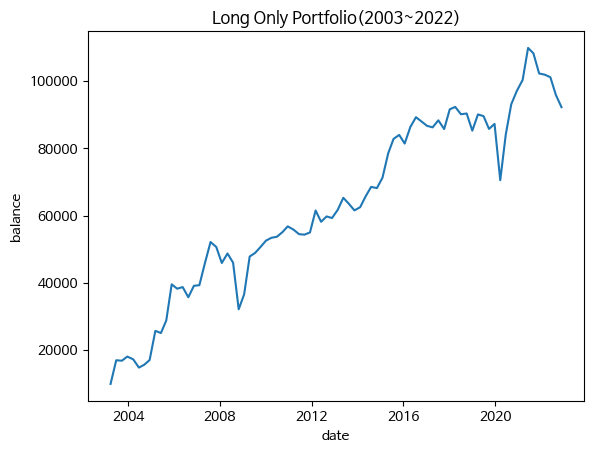

In [190]:
sns.lineplot(x='date', y='balance', data = results)
plt.title('Long Only Portfolio(2003~2022)')

Text(0.5, 1.0, 'Long Only Portfolio(2003~2022)')

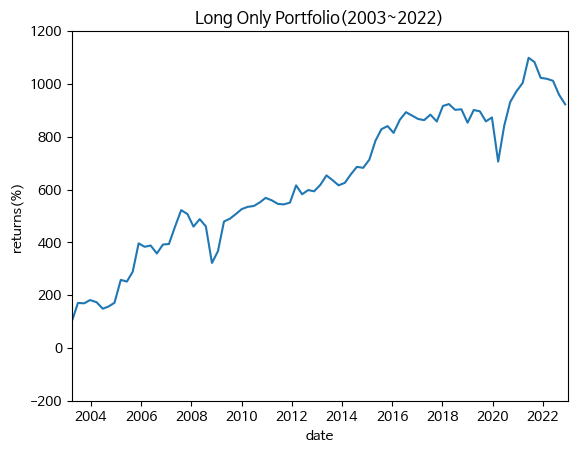

In [189]:
sns.lineplot(x='date', y='returns(%)', data= results)
plt.ylim(-200, 1200)
plt.xlim(datetime.date(2003, 3,28), datetime.date(2022,12,31))
plt.title('Long Only Portfolio(2003~2022)')

In [196]:
market_mom = stock_data[stock_data['날짜'].isin(dt[rbl_period::rbl_period])].groupby(by='날짜').mean().reset_index()
market_mom

C:\Users\kim56\AppData\Local\Temp\ipykernel_28212\345297200.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  market_mom = stock_data[stock_data['날짜'].isin(dt[rbl_period::rbl_period])].groupby(by='날짜').mean().reset_index()


,날짜,시가,고가,저가,종가,거래량,등락률,ABS_MOM
0,2003-03-28,95954.758231,99946.860771,93821.542803,97399.289746,435609.936030,1.119629,1.273584
1,2003-06-26,103556.155576,107370.250234,102334.351453,105016.557638,437947.536082,-0.289111,-0.406662
2,2003-09-25,94012.559259,99488.481481,91757.287963,96716.209259,284632.629630,-1.441765,-1.504056
3,2003-12-19,85686.177169,87213.158904,81617.165297,83585.154338,319402.428311,-0.366249,-0.435451
4,2004-03-23,68459.482914,70328.989209,65705.837230,67083.829137,313568.822842,-0.276513,-0.397199
...,...,...,...,...,...,...,...,...
77,2021-12-02,25098.238191,25995.602745,24688.671780,25891.113040,642230.570044,1.747303,1.673360
78,2022-03-03,23982.995146,24445.275485,23665.328074,24742.842638,657783.347492,1.227835,1.179030
79,2022-05-30,24192.154815,24552.359610,23933.138968,24423.832182,583117.878911,1.242615,1.237207
80,2022-08-25,22106.230738,22546.242968,21869.635548,22426.979209,421866.802283,1.405583,1.445664


In [222]:
kospi = fdr.DataReader('KS11', '2003').reset_index()
kospi_index = kospi[kospi['Date'].isin(dt[rbl_period::rbl_period])].groupby(by='Date').mean().reset_index()
kospi_index_close = kospi_index['Close']
scaled_index = ((1+(kospi_index_close - kospi_index_close.min())/kospi_index_close.max())*100).to_frame()
scaled_index['Date'] = dt[rbl_period::rbl_period]
scaled_index

,Close,Date
0,100.000000,2003-03-28
1,103.713100,2003-06-26
2,104.887475,2003-09-25
3,107.924619,2003-12-19
4,109.633788,2004-03-23
...,...,...
77,174.278804,2021-12-02
78,168.116527,2022-03-03
79,165.709318,2022-05-30
80,159.727069,2022-08-25


Text(0.5, 1.0, 'Momentum VS. Long Only Portfolio during 2003 ~ 2022')

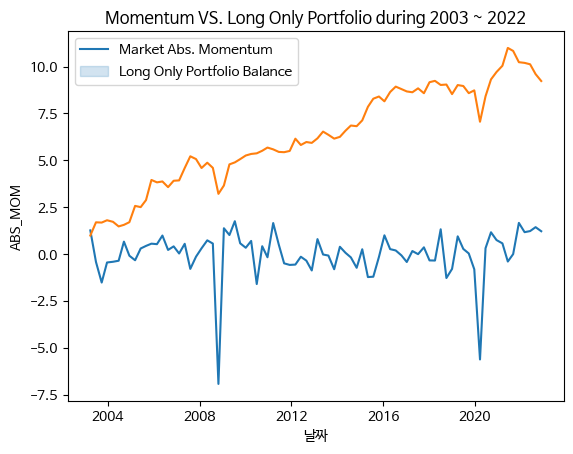

In [229]:
sns.lineplot(x='날짜', y='ABS_MOM', data = market_mom)
sns.lineplot(x='date', y='scaled_balance', data = results)
plt.legend(['Market Abs. Momentum', 'Long Only Portfolio Balance'])
plt.title('Momentum VS. Long Only Portfolio during 2003 ~ 2022')

Text(0.5, 1.0, 'KOSPI VS. Long Only Portfolio during 2003 ~ 2022')

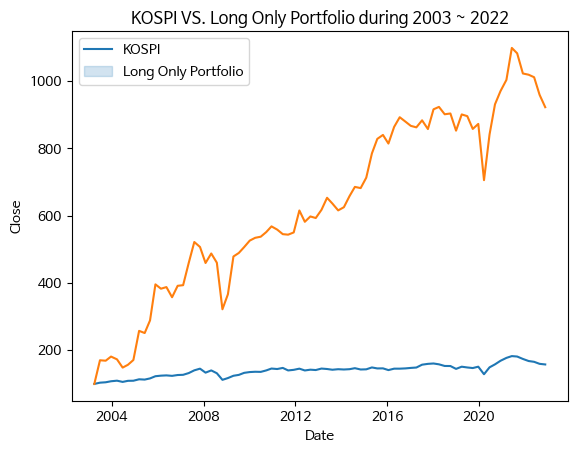

In [228]:
sns.lineplot(x='Date', y='Close', data =scaled_index)
sns.lineplot(x='date', y='returns(%)', data = results)
plt.legend(['KOSPI', 'Long Only Portfolio'])
plt.title('KOSPI VS. Long Only Portfolio during 2003 ~ 2022')

### *PS. Calculating Momentum Factor

In [7]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import time


stock_data = pd.read_csv('C:\\Users\\kim56\\anaconda3\\Find-A\\quant\\Fama_French\\factor_data.csv', index_col = 0, parse_dates=['날짜'], dtype = {'티커' : 'str'})

window = 252

tickers = stock_data['티커'].unique()
dt = pd.DataFrame(stock_data['날짜'].unique(), columns = ['날짜'])
abs_momentums = []

for i, ticker in enumerate(tickers) : 
    start = time.time()
    stock = stock_data[stock_data['티커'] == ticker]
    dt['티커'] = ticker
    momentum = stock['등락률'].rolling(window = window, min_periods = 1).mean()
    abs_momentum = pd.DataFrame(stock['등락률'] - momentum)
    abs_momentum.rename(columns = {'등락률' : 'ABS_MOM'}, inplace = True)
    abs_momentum['티커'] = ticker
    stock = pd.concat([stock, abs_momentum], axis = 1)
    stock = pd.merge(stock, dt, how = 'right', on = ['티커', '날짜'])
    abs_momentums.append(stock)
    end = time.time()
    print(f'[{i+1}/{len(tickers)}]({ticker}) was completed ... ({end - start:.5f} sec) ')
    
stock_data_mom = pd.concat(abs_momentums)
stock_data_mom.to_csv('./mom_data.csv')

[1/2514](060310) was completed ... (1.93925 sec) 
[2/2514](095570) was completed ... (1.98559 sec) 
[3/2514](006840) was completed ... (1.84654 sec) 
[4/2514](054620) was completed ... (1.83697 sec) 
[5/2514](265520) was completed ... (1.68750 sec) 
[6/2514](211270) was completed ... (1.83309 sec) 
[7/2514](027410) was completed ... (1.76843 sec) 
[8/2514](282330) was completed ... (1.88176 sec) 
[9/2514](126600) was completed ... (1.75531 sec) 
[10/2514](138930) was completed ... (1.76260 sec) 
[11/2514](001460) was completed ... (1.74881 sec) 
[12/2514](001465) was completed ... (1.81246 sec) 


,티커,종목명,날짜,시가,고가,저가,종가,거래량,등락률,ABS_MOM
0,060310,3S,2003-01-02,1037.0,1107.0,1007.0,1081.0,164270.0,7.135778,0.000000
1,060310,3S,2003-01-03,1095.0,1173.0,1095.0,1111.0,238965.0,2.775208,-2.180285
2,060310,3S,2003-01-06,1114.0,1132.0,1075.0,1119.0,144530.0,0.720072,-2.823614
3,060310,3S,2003-01-07,1138.0,1187.0,1095.0,1111.0,168800.0,-0.714924,-3.193958
4,060310,3S,2003-01-08,1101.0,1126.0,1074.0,1086.0,132570.0,-2.250225,-3.783407
...,...,...,...,...,...,...,...,...,...,...
4942,001465,BYC우,2022-12-23,140000.0,140000.0,139000.0,140000.0,81.0,0.000000,0.041550
4943,001465,BYC우,2022-12-26,140000.0,141500.0,140000.0,141000.0,173.0,0.714286,0.760173
4944,001465,BYC우,2022-12-27,142000.0,143000.0,141000.0,142500.0,41.0,1.063830,1.103147
4945,001465,BYC우,2022-12-28,142500.0,142500.0,140500.0,141500.0,14.0,-0.701754,-0.660833
